# Slope profile analysis

This notebook takes a slope profile obtained from a Lidar DEM across a normal fault and conducts additional analysis.

## Import scientific Python packages

```matplotlib``` will help us make plots. ```pandas``` will help us import and manipulate data. ```numpy``` will help us make calculations.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Import slope data

This code will import the data from a DEM profile (say that obtained using the qProf QGIS plugin).

In [2]:
slope_profile = pd.read_csv('./data/example_dem_transect.csv')
slope_profile['L_x (m)'] = slope_profile['cds2d']
slope_profile['EL (m)'] = slope_profile['output_be']

## Plot slope data

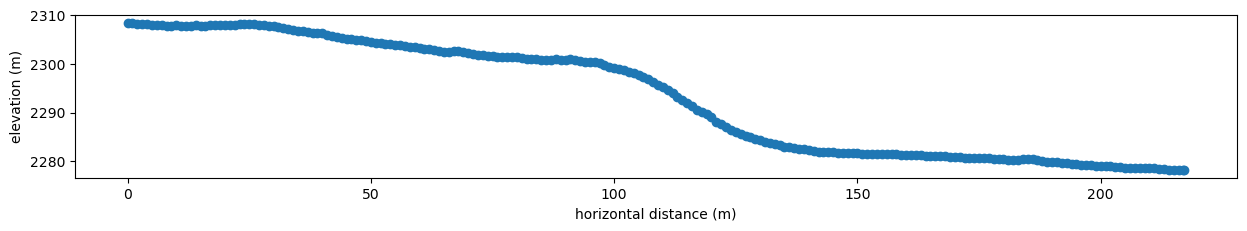

In [3]:
plt.figure(figsize=(15,15))
plt.scatter(slope_profile['L_x (m)'], slope_profile['EL (m)'])
plt.xlabel('horizontal distance (m)')
plt.ylabel('elevation (m)')
plt.axis('scaled')
plt.show()

## Analyzing fault offset

To consider fault offset, we need to deal with the reality that there is a background slope both in the valley and on the moraine crest. Divide the slope profile into:
- a portion above the fault scarp (upper slope)
- a portion on the fault scarp (fault)
- a portion below the scarp (lower slope)

**Adjust the start and end values below to match ones that make sense for your profile.**

In [16]:
upper_slope_start = 70
upper_slope_end = 90

fault_start = 110
fault_end = 125

lower_slope_start = 150
lower_slope_end = 170

slope_profile_upper = slope_profile[(slope_profile['L_x (m)']>upper_slope_start) 
                                    & (slope_profile['L_x (m)']<upper_slope_end)]
slope_profile_fault = slope_profile[(slope_profile['L_x (m)']>fault_start)
                                    & (slope_profile['L_x (m)']<fault_end)]
slope_profile_lower = slope_profile[(slope_profile['L_x (m)']>lower_slope_start) 
                                    & (slope_profile['L_x (m)']<lower_slope_end)]

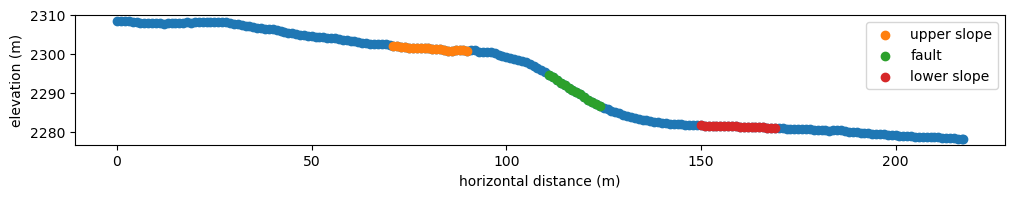

In [20]:
plt.figure(figsize=(12,12))
plt.scatter(slope_profile['L_x (m)'], slope_profile['EL (m)'])
plt.scatter(slope_profile_upper['L_x (m)'], 
            slope_profile_upper['EL (m)'], label='upper slope')
plt.scatter(slope_profile_fault['L_x (m)'], 
            slope_profile_fault['EL (m)'], label='fault')
plt.scatter(slope_profile_lower['L_x (m)'], 
            slope_profile_lower['EL (m)'], label='lower slope')
plt.legend()
plt.xlabel('horizontal distance (m)')
plt.ylabel('elevation (m)')
plt.axis('scaled')
plt.show()

## Fit linear regressions to the slope above and below the fault

We can use the function `np.polyfit()` to fit the upper slope and the lower slope intervals. The function takes x values, y values, polynomial degree. We want to set the polynomial degree to be 1 to make a linear fit.

\begin{equation}
y = mx + b
\end{equation}

The function `np.polyfit()` returns the slope ($m$ in equation 1) and the intercept ($b$ in equation 1). We will save those values to use them later for plotting and analysis.

In [6]:
upper_slope, upper_intercept = np.polyfit(slope_profile_upper['L_x (m)'], 
                                          slope_profile_upper['EL (m)'], 1)

lower_slope, lower_intercept = np.polyfit(slope_profile_lower['L_x (m)'], 
                                          slope_profile_lower['EL (m)'], 1)

**Define the distance along the profile that is the midpoint of the fault to be the `fault_midpoint`** 

In [7]:
fault_midpoint = 118

Plot the slope profiles along with the linear fits to them. Ideally, the linear fits should be parallel to one another.

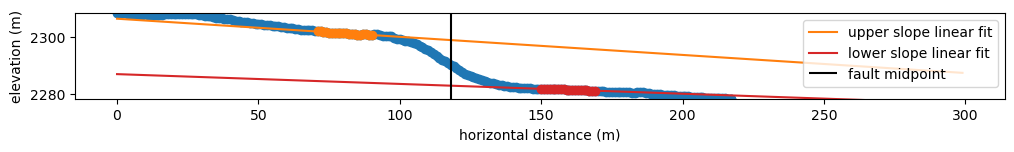

In [24]:
x = np.arange(0, 300, 1)

plt.figure(figsize=(12,12))
plt.scatter(slope_profile['L_x (m)'], slope_profile['EL (m)'])

plt.scatter(slope_profile_upper['L_x (m)'], slope_profile_upper['EL (m)'],color='C1')
plt.plot(x, upper_slope*x + upper_intercept,color='C1',label='upper slope linear fit')

plt.scatter(slope_profile_lower['L_x (m)'], slope_profile_lower['EL (m)'],color='C3')
plt.plot(x, lower_slope*x + lower_intercept,color='C3',label='lower slope linear fit')

plt.vlines(fault_midpoint,0,3000,color='black',label='fault midpoint')

plt.axis('scaled')
plt.ylim(np.min(slope_profile['EL (m)']),np.max(slope_profile['EL (m)']))
plt.xlabel('horizontal distance (m)')
plt.ylabel('elevation (m)')
plt.legend()
plt.show()

## Calculate the vertical offset between the upper and lower lines at the fault

We can calculate the elevation on the upper slope and lower slope lines at the midpoint of the fault.

The difference between these lines is the drop in elevation associated with the fault.

In [25]:
foot_wall_z = upper_slope*fault_midpoint + upper_intercept
print('footwall wall elevation at ' + str(fault_midpoint) + ' m along profile: ' + str(round(foot_wall_z,1)))

hanging_wall_z = lower_slope*fault_midpoint + lower_intercept
print('hanging wall elevation at ' + str(fault_midpoint) + ' m along profile: ' + str(round(hanging_wall_z,1)))

difference = foot_wall_z-hanging_wall_z
print('fault drop in elevation is ' + str(round(difference,1)) + ' m')

footwall wall elevation at 118 m along profile: 2298.9
hanging wall elevation at 118 m along profile: 2282.8
fault drop in elevation is 16.1 m


## Fit a linear regression to the fault slope

Similar to how we fit the upper and lower slopes, we can fit a linear regression to the slope on the fault scarp.

In [26]:
fault_scarp_slope, fault_scarp_intercept = np.polyfit(slope_profile_fault['L_x (m)'], 
                                                      slope_profile_fault['EL (m)'],1)

We can calculate the angle of the slope from this fit:

In [27]:
slope_angle = np.rad2deg(np.arctan(fault_scarp_slope/1))
print(round(slope_angle,1))

-32.1


## Determine fault scarp slope intercepts

We can determine the intersects of the fault scarp slope with the upper and lower slopes.

Let's consider the linear equation for the upper slope:
\begin{equation*}
y = \text{upper\_slope} \cdot x + \text{upper\_intercept}
\end{equation*}

and that for the fault scarp slope:
\begin{equation*}
y = \text{fault\_scarp\_slope} \cdot x + \text{fault\_scarp\_intercept}
\end{equation*}

We can then set the equations equal to each other and solve for x in order to determine the intercept x value.

\begin{equation*}
x_{\text{upper\_intersect}} = \frac{\text{upper\_intercept} - \text{fault\_scarp\_intercept}}{\text{upper\_slope} - \text{fault\_scarp\_slope}}
\end{equation*}

We can then plug that x value into the fault scarp slope equation to determine the y value of the intercept:

\begin{equation*}
y_{\text{upper\_intersect}} = \text{fault\_scarp\_slope} \cdot x_{\text{upper\_intersect}} + \text{fault\_scarp\_intercept}
\end{equation*}

In [12]:
x_upper_intersect = (fault_scarp_intercept - upper_intercept) / (upper_slope - fault_scarp_slope)
y_upper_intersect = fault_scarp_slope * x_upper_intersect + fault_scarp_intercept

We can then do the same to solve for the lower intercept.

In [28]:
x_lower_intersect = (lower_intercept- fault_scarp_intercept) / (fault_scarp_slope - lower_slope)
y_lower_intersect = fault_scarp_slope * x_lower_intersect + fault_scarp_intercept

These intercepts are plotted as black squares below:

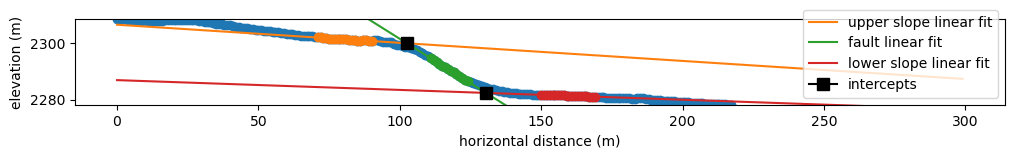

In [30]:
x = np.arange(0, 300, 1)

plt.figure(figsize=(12,12))
plt.scatter(slope_profile['L_x (m)'], slope_profile['EL (m)'])

plt.scatter(slope_profile_upper['L_x (m)'], slope_profile_upper['EL (m)'],color='C1')
plt.plot(x, upper_slope*x + upper_intercept,color='C1',label='upper slope linear fit')

plt.scatter(slope_profile_fault['L_x (m)'], slope_profile_fault['EL (m)'],color='C2')
plt.plot(x, fault_scarp_slope*x + fault_scarp_intercept,color='C2',label='fault linear fit')

plt.scatter(slope_profile_lower['L_x (m)'], slope_profile_lower['EL (m)'],color='C3')
plt.plot(x, lower_slope*x + lower_intercept,color='C3',label='lower slope linear fit')

plt.plot(x_upper_intersect,y_upper_intersect,color='black',
         marker='s',markersize=8,label='intercepts')
plt.plot(x_lower_intersect,y_lower_intersect,color='black',marker='s',markersize=8)

plt.axis('scaled')
plt.legend()
plt.xlabel('horizontal distance (m)')
plt.ylabel('elevation (m)')
plt.ylim(np.min(slope_profile['EL (m)']),np.max(slope_profile['EL (m)']))
plt.show()

## Calculate offset along the fault scarp plane

If the current surface of the slope is the fault plane we can calculate the offset along the plane (once again pythagorean theorem comes in handy!)

In [14]:
x = x_lower_intersect - x_upper_intersect
y = y_upper_intersect - y_lower_intersect
fault_scarp_offset = np.sqrt(x**2 + y**2)
fault_scarp_offset

33.03579211049754

## Determining the orientation of the fault plane and calculate the dip slip offset

However, there have been ongoing hillslope processes eroding the scarp as it progressively develops through earthquakes such that the fault scarp angle is likely less than the true fault angle. This difference will make the fault_scarp_offset estimate above an overestimate of the dip slip displacement along the fault plane itself.

To determine how much slip there has been on the fault, we need to know the angle of the fault plane. One way that we can get at this information is not through the slope on the fault scarp, but rather the intersection of the fault with the landscape. In EPS 101, you took measured bedding plane measurements and plotted their intersection with the topography. We can flip this approach around and use the intersection of a plane with the topography as a way to back out the fault orientation.

**To do**
- Calculate the fault plane orientation using the Best fit plane tool of the qgSurf plugin within QGIS using the expression of the fault in conjunction with the DEM
- Calculate the slope from this fault dip
- Calculate the intercept such that it can be plotted with the upper and lower slope lines. Recall that you know the slope of a line and a point along the line you can solve for the intercept. The point on the line can be the fault midpoint distance and the fault midpoint elevation.
- Calculate the intersections of the line with the upper and lower slope lines.
- Plot this line with the upper and lower slope lines.
- Determine the total slip along the plane in the down going direction on the fault plane (this is the dip slip offset)


In [15]:
fault_dip_direction = 
fault_dip = 

SyntaxError: invalid syntax (1000046695.py, line 1)

In [ ]:
fault_slope =
fault_slope

In [ ]:
fault_midpoint_x = 
fault_midpoint_z = 
fault_intercept = 
fault_intercept

In [ ]:
dip_slip_offset =

##  Determining the total offset along the fault

The total offset along the fault will be a combination of the dip slope offset you have just estimated and the strike slip offset. 

**To do**
- Estimate the strike slip offset using the offset moraine crests
- Determine the total slip along the fault plane using the dip slip offset and strike slip offset values (Pythagorean theorem comes in handy once again)